In [1]:
!pip install yfinance timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 558.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
import time
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import timesfm

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

In [ ]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

model = timesfm.TimesFm(
    context_len=32,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")


In [147]:

# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Calculate moving averages
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()

# Drop rows with NaN values (caused by rolling window calculations)
data = data.dropna()

# Prepare DataFrame
df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50
date,,,,
2023-03-15,152.990005,77167900,151.038000,144.793400
2023-03-16,155.850006,76161100,152.032001,145.409000
2023-03-17,155.000000,98944600,152.429001,145.981800
2023-03-20,157.399994,73641400,152.786000,146.629400
2023-03-21,159.279999,73938300,153.553999,147.222600
...,...,...,...,...
2023-12-22,193.600006,37122800,195.747002,185.398801
2023-12-26,193.050003,28919300,195.734003,185.682801
2023-12-27,193.149994,48087700,195.578001,185.971400


In [148]:
# Prepare data for TimesFM
def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        examples["inputs"].append(df["close"][start:(context_end := start + context_len)].tolist())
        examples["volume"].append(df["volume"][start:context_end + horizon_len].tolist())
        examples["moving_avg_10"].append(df["moving_avg_10"][start:context_end + horizon_len].tolist())
        examples["moving_avg_50"].append(df["moving_avg_50"][start:context_end + horizon_len].tolist())
        examples["outputs"].append(df["close"][context_end:(context_end + horizon_len)].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [149]:

# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [150]:







# Benchmark
batch_size = 32
context_len = 32
horizon_len = 1

input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
metrics = defaultdict(list)

results = []

for i, example in enumerate(input_data()):
    raw_forecast, _ = model.forecast(
        inputs=example["inputs"], freq=[0] * len(example["inputs"])
    )
    start_time = time.time()
    print(len(example["volume"][0]))

    # Forecast with covariates
    # Output: new forecast, forecast by the xreg
    cov_forecast, ols_forecast = model.forecast_with_covariates(
        inputs=example["inputs"],
        dynamic_numerical_covariates={
            "volume": example["volume"],
            "moving_avg_10": example["moving_avg_10"],
            "moving_avg_50": example["moving_avg_50"],
        },
        dynamic_categorical_covariates={},
        static_numerical_covariates={},
        static_categorical_covariates={},
        freq=[0] * len(example["inputs"]),
        # xreg_mode="timesfm + xreg",  # default
        ridge=0.0,
        force_on_cpu=False,
        normalize_xreg_target_per_input=True,  # default
    )
    end_time = time.time()
    print(
        f"\rFinished batch {i} linear in {end_time - start_time} seconds",
        end="",
    )

    for j in range(len(example["inputs"])):
        result = {

            'batch': i,
            'input_index': j,
            'train_start_date': example["dates"][j][0],  # Start date of the training data
            'train_end_date': example["dates"][j][-2],  # End date of the training data
            'predict_date': example["dates"][j][-1],  # Prediction date
            'raw_forecast': raw_forecast[j][0],
            'y_actual': example["outputs"][j][-1],
            'y_predicted': cov_forecast[j][0],

        }
        results.append(result)

results_df = pd.DataFrame(results)
print(results_df)




33
Finished batch 0 linear in 0.06195878982543945 seconds33
Finished batch 1 linear in 0.06072282791137695 seconds33
Finished batch 2 linear in 0.06509757041931152 seconds33
Finished batch 3 linear in 0.06257772445678711 seconds33
Finished batch 4 linear in 0.06668901443481445 seconds33
Finished batch 5 linear in 0.033746957778930664 seconds     batch  input_index train_start_date train_end_date predict_date  \
0        0            0       2023-03-15     2023-04-28   2023-05-01   
1        0            1       2023-03-16     2023-05-01   2023-05-02   
2        0            2       2023-03-17     2023-05-02   2023-05-03   
3        0            3       2023-03-20     2023-05-03   2023-05-04   
4        0            4       2023-03-21     2023-05-04   2023-05-05   
..     ...          ...              ...            ...          ...   
163      5            3       2023-11-06     2023-12-20   2023-12-21   
164      5            4       2023-11-07     2023-12-21   2023-12-22   
165      

In [151]:
results_df

,batch,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,y_predicted
0,0,0,2023-03-15,2023-04-28,2023-05-01,168.654968,169.589996,168.505127
1,0,1,2023-03-16,2023-05-01,2023-05-02,168.828140,168.539993,168.503296
2,0,2,2023-03-17,2023-05-02,2023-05-03,168.470001,167.449997,168.438187
3,0,3,2023-03-20,2023-05-03,2023-05-04,167.213593,165.789993,167.084976
4,0,4,2023-03-21,2023-05-04,2023-05-05,165.798965,173.570007,167.796555
...,...,...,...,...,...,...,...,...
163,5,3,2023-11-06,2023-12-20,2023-12-21,195.307144,194.679993,196.334259
164,5,4,2023-11-07,2023-12-21,2023-12-22,194.781067,193.600006,195.399658
165,5,5,2023-11-08,2023-12-22,2023-12-26,193.867935,193.050003,194.549515
166,5,6,2023-11-09,2023-12-26,2023-12-27,192.631256,193.149994,194.661835


In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


mse_model = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
print(f'MSE for the predictive model: {mse_model}')

# محاسبه MSE برای پیش‌بینی ناهموار (فرض می‌کنیم قیمت فردا برابر با قیمت امروز است)
results_df['y_naive'] = results_df['y_actual'].shift(1)  # قیمت ناهموار
results_df.dropna(inplace=True)


mse_naive = mean_squared_error(results_df['y_actual'], results_df['y_naive'])
print(f'MSE for the naive prediction: {mse_naive}')



MSE for the predictive model: 4.3094307666774725
MSE for the naive prediction: 4.5522674217438155


In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


mse_model = mean_squared_error(results_df['y_actual'], results_df['raw_forecast'])
print(f'MSE for the predictive model: {mse_model}')




MSE for the predictive model: 5.2252837369583744


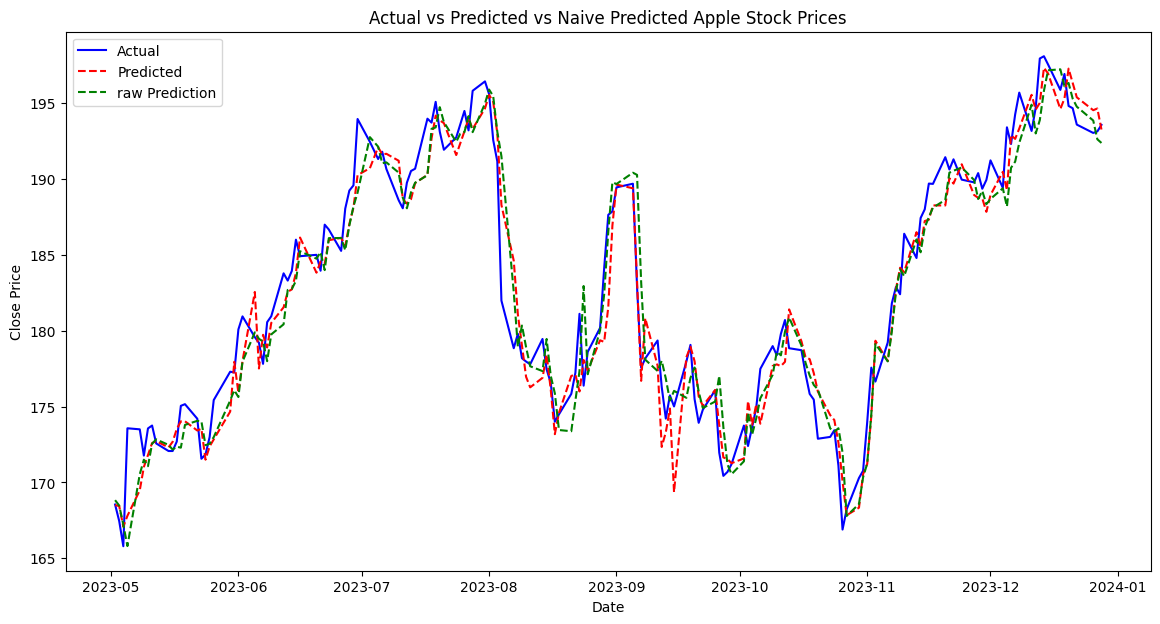

In [154]:
# رسم نمودار مقایسه‌ای
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['predict_date'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
# plt.plot(results_df['ds'], results_df['y_naive'], label='Naive Prediction', color='green', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='raw Prediction', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted vs Naive Predicted Apple Stock Prices')
plt.legend()
plt.show()


In [155]:
import pandas as pd



# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Iterate through each row in the DataFrame
for i in range(1, len(results_df)):
    # Get actual and predicted prices for the current and previous days
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['y_predicted']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['predict_date']

    # Check if the date of the previous row is the previous day of the current row
    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['predict_date']) - pd.DateOffset(days=1):
        continue  # Skip this row if the previous date is not the previous day

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    # Calculate actual and predicted movements
    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday  # We use yesterday's actual price as reference

    # Check if the directions of actual and predicted movements match
    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.6153846153846154


# raw_forecast

In [156]:
import pandas as pd



# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Iterate through each row in the DataFrame
for i in range(1, len(results_df)):
    # Get actual and predicted prices for the current and previous days
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['raw_forecast']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['predict_date']

    # Check if the date of the previous row is the previous day of the current row
    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['predict_date']) - pd.DateOffset(days=1):
        continue  # Skip this row if the previous date is not the previous day

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    # Calculate actual and predicted movements
    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday  # We use yesterday's actual price as reference

    # Check if the directions of actual and predicted movements match
    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.49230769230769234


# buy_sell_all_capital

Total Profit: 27.23 USD
    predict_date    y_actual  y_predicted signal  buy_sell_all_capital
1     2023-05-02  168.539993   168.503296   Sell            100.000000
2     2023-05-03  167.449997   168.438187   Sell            100.000000
3     2023-05-04  165.789993   167.084976    Buy            100.000000
4     2023-05-05  173.570007   167.796555    Buy            104.692692
5     2023-05-08  173.500000   169.475250    Buy            104.650466
..           ...         ...          ...    ...                   ...
163   2023-12-21  194.679993   196.334259   Sell            127.162059
164   2023-12-22  193.600006   195.399658   Sell            127.162059
165   2023-12-26  193.050003   194.549515    Buy            127.162059
166   2023-12-27  193.149994   194.661835   Sell            127.227922
167   2023-12-28  193.580002   193.275436   Sell            127.227922

[167 rows x 5 columns]


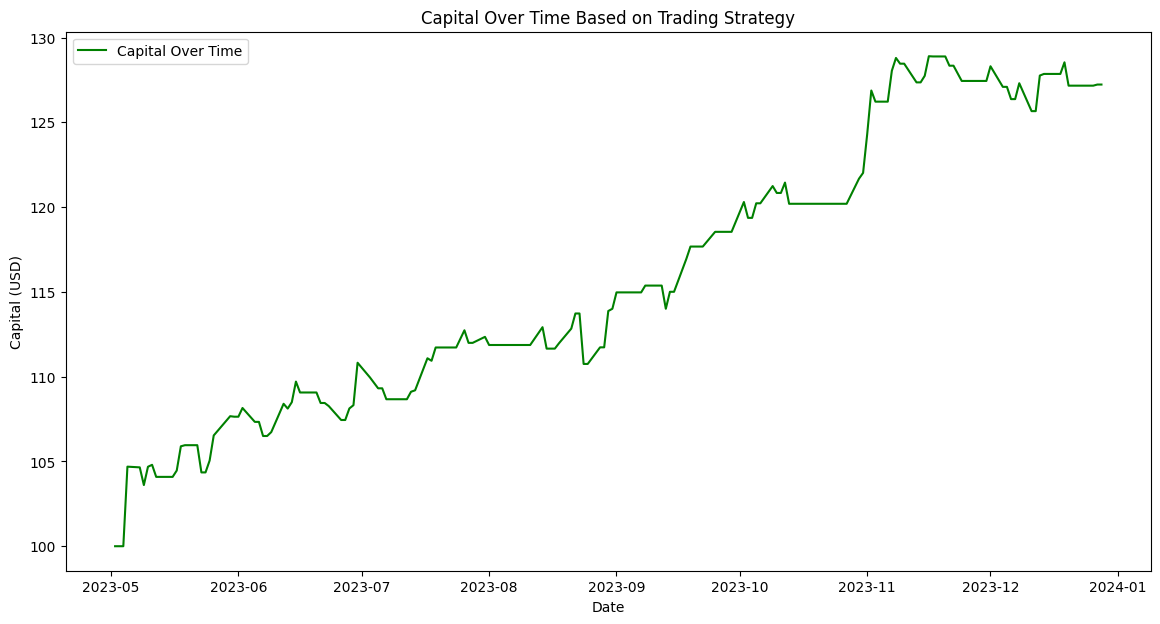

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['predict_date', 'y_actual', 'y_predicted', 'signal', 'buy_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['buy_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['predict_date', 'y_actual', 'y_predicted', 'signal', 'buy_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['buy_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# naive_capital

Total Profit: 11.69 USD
    predict_date    y_actual  raw_forecast signal  raw_forecast_capital
1     2023-05-02  168.539993    168.828140   Sell            100.000000
2     2023-05-03  167.449997    168.470001   Sell            100.000000
3     2023-05-04  165.789993    167.213593   Sell            100.000000
4     2023-05-05  173.570007    165.798965    Buy            100.000000
5     2023-05-08  173.500000    170.532333    Buy             99.959666
..           ...         ...           ...    ...                   ...
163   2023-12-21  194.679993    195.307144   Sell            111.693736
164   2023-12-22  193.600006    194.781067   Sell            111.693736
165   2023-12-26  193.050003    193.867935   Sell            111.693736
166   2023-12-27  193.149994    192.631256   Sell            111.693736
167   2023-12-28  193.580002    192.389862   Sell            111.693736

[167 rows x 5 columns]


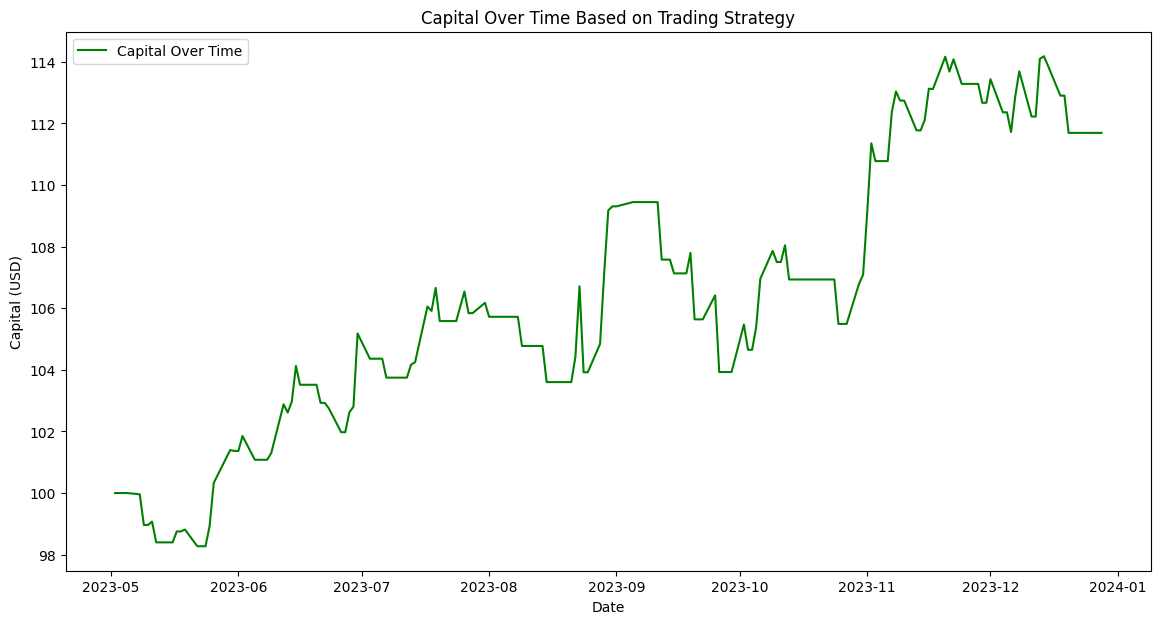

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['raw_forecast'].shift(-1) > results_df['raw_forecast'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []


# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['raw_forecast_capital'] = capital_history + [final_capital]
print(results_df[['predict_date', 'y_actual', 'raw_forecast', 'signal', 'raw_forecast_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['raw_forecast_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


# buy_and_hold_profit

In [159]:
initial_investment = 100
buy_and_hold_final_value = initial_investment * (results_df['y_actual'].iloc[-1] / results_df['y_actual'].iloc[0])
buy_and_hold_profit = buy_and_hold_final_value - initial_investment
buy_and_hold_profit

14.857012900440239